In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import ensemble
from sklearn import linear_model
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler  
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.decomposition import PCA
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

C:\Users\boyerm\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\boyerm\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Set up Test/Train for Clustering

In [3]:
## IMPORT latest dataset:

data = pd.read_csv('all_features5.csv',index_col = None)
data = data.drop('Unnamed: 0',axis = 1)
data.shape

(1516, 170)

In [4]:
data_clean = data.dropna(axis=0, how='any')
X = data_clean
X = X.drop(['filenum','filename','classified_shape'] , axis = 1)
X_norm = normalize(X)
Y = data_clean['classified_shape']
X.shape

(1496, 167)

# Supervised Learning

In [12]:
# Standardize features by removing the mean and scaling to unit variance

scaler = StandardScaler()  
scaler.fit(X)  

X = scaler.transform(X)

X_train, X_test, Y_train, Y_test = train_test_split(
    X,Y,
    test_size=0.25,
    random_state=1200)


### Use PCA for dimension reduction

In [13]:
n_components = 18
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X)


# print(
#     'The percentage of total variance in the dataset explained by each',
#     'component from Sklearn PCA.\n',
#     pca.explained_variance_ratio_)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)


In [14]:
# #Remove PCA 

X_train_pca = X_train
X_test_pca = X_test

## Neural Network (MLP)

In [15]:
# used randomsearch to find these are the right parameters (See MAIN v2)

mlp_best = MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(60, 100, 30, 100), learning_rate='constant',
       learning_rate_init=0.01, max_iter=100, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=525,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

mlp_best.fit(X_train_pca, Y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(60, 100, 30, 100), learning_rate='constant',
       learning_rate_init=0.01, max_iter=100, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=525,
       shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [16]:
print(mlp_best.score(X_train_pca,Y_train))
mlp_score = mlp_best.score(X_test_pca,Y_test)
print(mlp_score)

y_pred = mlp_best.predict(X_test_pca)
 
mlp_crosstab = pd.crosstab(Y_test, y_pred, margins=True)
mlp_crosstab

1.0
0.729946524064


col_0,heart,long,oval,round,square,All
classified_shape,,,,,,
heart,49,4,12,7,1,73
long,2,44,6,2,4,58
oval,12,8,62,6,4,92
round,4,1,1,70,3,79
square,3,7,11,3,48,72
All,70,64,92,88,60,374


In [ ]:
#print(classification_report(Y_test,y_pred))


In [37]:
results_df = pd.DataFrame()

In [38]:
# Get the RECALL for each shape and overall
correct_list =[]
shape_list = []
for i in mlp_crosstab.index[0:5]:
    correct = (mlp_crosstab.at[i,i]/mlp_crosstab.at[i,'All'])
    correct = round(correct,2)* 100
    shape_list.append(i)
    correct_list.append(correct)

shape_list.append('Overall')
correct_list.append(round(mlp_score,2)*100)

results_df['shape']= shape_list
results_df['MLP']=correct_list


## KNN Classifier

In [39]:
# use the loop  below to fine tune the K hyperparameter
nn = []
score = []
cv_scores = []
neighbors = range(2,30)
for n in neighbors:
    neigh = KNeighborsClassifier(n_neighbors=n) 
    neigh.fit(X_train_pca, Y_train) 
    sc = neigh.score(X_test_pca,Y_test)
    scores = cross_val_score(neigh, X_train, Y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    nn.append(n)
    score.append(sc)


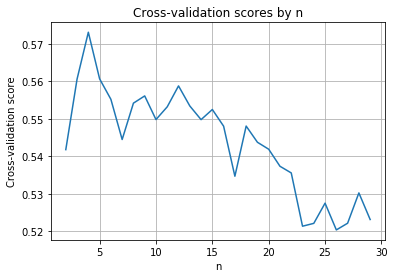

In [40]:
plt.plot(nn,cv_scores)
plt.title('Cross-validation scores by n')
plt.ylabel('Cross-validation score')
plt.xlabel('n')
plt.grid()
plt.show()

The optimal number of neighbors is 4


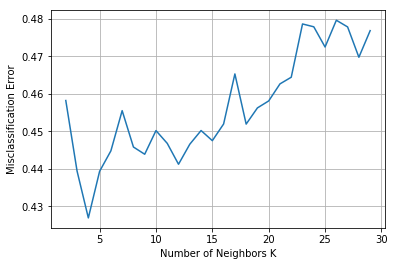

In [41]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.grid()
plt.show()

In [42]:
neigh = KNeighborsClassifier(n_neighbors=optimal_k) 
neigh.fit(X_train_pca, Y_train) 
print(neigh.score(X_train_pca,Y_train))
print(neigh.score(X_test_pca,Y_test))
y_pred = neigh.predict(X_test_pca)

KNN_crosstab = pd.crosstab(Y_test, y_pred,margins = True) 
KNN_crosstab

0.780748663102
0.582887700535


col_0,heart,long,oval,round,square,All
classified_shape,,,,,,
heart,44,8,12,5,4,73
long,3,43,8,1,3,58
oval,15,16,48,6,7,92
round,7,5,6,57,4,79
square,8,13,17,8,26,72
All,77,85,91,77,44,374


In [ ]:
# print(cross_val_score(neigh, X, Y, cv=5))
# print(classification_report(Y_test,y_pred))

In [43]:
correct_list =[]
for i in KNN_crosstab.index[0:5]:
    correct = (KNN_crosstab.at[i,i]/KNN_crosstab.at[i,'All'])
    correct = round(correct,2)* 100
    correct_list.append(correct)

correct_list.append(round(neigh.score(X_test_pca,Y_test),2)*100)
results_df['KNN']=correct_list

### Random Forest Classifier

In [94]:
# don't need to run each time
clf = RandomForestClassifier(max_depth=None, random_state=5,n_estimators=90,max_features='sqrt',
                            min_samples_leaf=5,min_samples_split=15,criterion='entropy', bootstrap=True)
clf.fit(X_train_pca, Y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=15,
            min_weight_fraction_leaf=0.0, n_estimators=90, n_jobs=1,
            oob_score=False, random_state=5, verbose=0, warm_start=False)

### Notes on hyperparameters for Random Forest
min_samples_leaf - lower, way overfit because it allows leaf size to be 1;
A smaller leaf makes the model more prone to capturing noise in train data.
At default (1), there was significant overfitting; as I increased min_samples_leaf, 
the scores for both train and test decreased, but for training, there was more decline, reducing overfitting.

random state - so my #s don't change

n_estimators (The number of trees in the forest.) - higher # takes longer but makes predictions stronger and more stable.

criterion did not make a difference, entropy slightly better and more stable with CV; documentation says there is little difference

max depth - The maximum depth of the tree. As None, nodes are expanded until all leaves are pure
           or until all leaves contain less than min_samples_split samples

I set min_samples_split to be 15 (default is 2) to try to reduce noise from small sample size. 
  At 2, the model was significantly overfit; at 15, less so.
  
I toggled many other parameters but found little difference in performance as I changed them.


In [95]:
## Takes a while to run! just use the rf_best to save time since that is random search already run

param_grid = { 
    'n_estimators': [50,150, 250, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
        'min_samples_leaf': [1,5,10,20,25],
        'min_samples_split': [2,5,10],
    'max_depth': [None,5,10,15,20,25],
    "criterion"         : ["gini", "entropy"],
     "bootstrap": [True]
}

rf_random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid, cv= 5, n_iter = 50)
rf_random_search.fit(X_train_pca, Y_train)
print(rf_random_search.best_estimator_)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=5, verbose=0, warm_start=False)


In [96]:
rf_best = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=1,
            oob_score=False, random_state=5, verbose=0, warm_start=False)
rf_best.fit(X_train_pca, Y_train)
print(rf_best.score(X_train_pca,Y_train))
print(rf_best.score(X_test_pca,Y_test))

y_pred = rf_best.predict(X_test_pca)

rfc_crosstab = pd.crosstab(Y_test, y_pred,margins = True) 
rfc_crosstab

1.0
0.631016042781


col_0,heart,long,oval,round,square,All
classified_shape,,,,,,
heart,43,8,10,7,5,73
long,1,40,10,1,6,58
oval,16,9,51,6,10,92
round,7,1,4,61,6,79
square,7,5,12,7,41,72
All,74,63,87,82,68,374


In [ ]:
# print(cross_val_score(rf_best, X, Y, cv=5))
# print(cross_val_score(rf_best, X, Y, cv=5).mean())

In [ ]:
# print(classification_report(Y_test,y_pred))

In [97]:
correct_list =[]
for i in rfc_crosstab.index[0:5]:
    correct = (rfc_crosstab.at[i,i]/rfc_crosstab.at[i,'All'])
    correct = round(correct,2)* 100
    correct_list.append(correct)

In [98]:
correct_list.append(round(rf_best.score(X_test_pca,Y_test),2)*100)
results_df['Random_Forest']=correct_list

### Gradient Boosting

In [ ]:
# GB is by far the slowest model to run

In [ ]:
### Don't need to run each time
# gb = ensemble.GradientBoostingClassifier()
# param_grid = {'n_estimators': [100,200,300],
#           'max_depth': [5,15,25],
#           'min_samples_leaf': [5,10,20,30],
#              'min_samples_split': [2,6,10]}

# gb_random_search = RandomizedSearchCV(estimator=gb, param_distributions=param_grid, cv= 5, n_iter = 10)
# gb_random_search.fit(X_train_pca, Y_train)
# print(gb_random_search.best_estimator_)

### notes on Hyperparameters for GB
max depth (The maximum depth of a tree, Used to control over-fitting as higher depth will allow model to 

learn relations very specific to a particular sample) at 2 works better than 10 or 20

increasing min_samples_leaf helped accuracy (default is 1), performed best at 20 (15 and 25 worse)

Initialize and fit the model.


In [48]:
gb_best = ensemble.GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=15,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=20, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
gb_best.fit(X_train_pca, Y_train)
print(gb_best.score(X_train_pca,Y_train))
print(gb_best.score(X_test_pca,Y_test))


1.0
0.657754010695


In [ ]:
# print(cross_val_score(gb_best, X, Y, cv=5))
# print(cross_val_score(gb_best, X, Y, cv=5).mean())

In [50]:
predict_train = gb_best.predict(X_train_pca)
predict_test = gb_best.predict(X_test_pca)

# Accuracy tables.
table_train = pd.crosstab(Y_train, predict_train, margins=True)
table_test = pd.crosstab(Y_test, predict_test, margins=True)

table_test

col_0,heart,long,oval,round,square,All
classified_shape,,,,,,
heart,52,6,8,4,3,73
long,1,35,14,1,7,58
oval,14,10,58,2,8,92
round,7,2,2,62,6,79
square,7,10,12,4,39,72
All,81,63,94,73,63,374


In [ ]:
#print(classification_report(Y_test,predict_test))

In [51]:
correct_list =[]
for i in table_test.index[0:5]:
    correct = (table_test.at[i,i]/table_test.at[i,'All'])
    correct = round(correct,2)* 100
    correct_list.append(correct)

correct_list.append(round(gb_best.score(X_test_pca,Y_test),2)*100)

results_df['Gradient_Boosting']=correct_list

## Linear Discriminant Analysis

In [77]:
# This runs quickly so can run each time if you want.

lda = LinearDiscriminantAnalysis()

param_grid = { 
    'n_components': [1,5,7,10],
    'solver': ['svd'],
    'tol':[0.001,0.01,0.1,0.5]
}
lda.fit(X_train_pca, Y_train)

lda_param_search = GridSearchCV(estimator=lda, param_grid=param_grid, cv= 5)
lda_param_search.fit(X_train_pca, Y_train)
print(lda_param_search.best_estimator_)

LinearDiscriminantAnalysis(n_components=1, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.1)


In [78]:
print(lda_param_search.score(X_train_pca, Y_train))
print(lda_param_search.score(X_test_pca, Y_test))

0.705882352941
0.636363636364


In [91]:
param_grid2 = { 
    'n_components': [1,2,3,10,20],
    'solver': ['eigen','lsqr'],
    'shrinkage': ['auto',0.2,0.5,0.7,1]
}


lda_param_search2 = GridSearchCV(estimator=lda, param_grid=param_grid2, cv= 5)
lda_param_search2.fit(X_train_pca, Y_train)
print(lda_param_search2.best_estimator_)

LinearDiscriminantAnalysis(n_components=1, priors=None, shrinkage='auto',
              solver='lsqr', store_covariance=False, tol=0.0001)


In [92]:
print(lda_param_search2.score(X_train_pca, Y_train))
print(lda_param_search2.score(X_test_pca, Y_test))

0.711229946524
0.636363636364


In [81]:
predict_test = lda_param_search.predict(X_test_pca)
table_test = pd.crosstab(Y_test, predict_test, margins=True)
table_test

col_0,heart,long,oval,round,square,All
classified_shape,,,,,,
heart,48,2,13,6,4,73
long,4,33,14,0,7,58
oval,14,11,50,7,10,92
round,3,0,7,57,12,79
square,2,5,11,4,50,72
All,71,51,95,74,83,374


In [82]:
# print(cross_val_score(lda_param_search, X, Y, cv=5))
# print(classification_report(Y_test,predict_test))

In [83]:
correct_list =[]
for i in table_test.index[0:5]:
    correct = (table_test.at[i,i]/table_test.at[i,'All'])
    correct = round(correct,2)* 100
    correct_list.append(correct)

correct_list.append(round(lda_param_search.score(X_test_pca,Y_test),2)*100)
results_df['LDA']=correct_list
results_df

,shape,MLP,KNN,Random_Forest,Gradient_Boosting,LDA
0,heart,73.0,60.0,59.0,71.0,66.0
1,long,71.0,74.0,69.0,60.0,57.0
2,oval,66.0,52.0,55.0,63.0,54.0
3,round,73.0,72.0,77.0,78.0,72.0
4,square,62.0,36.0,57.0,54.0,69.0
5,Overall,69.0,58.0,63.0,66.0,64.0


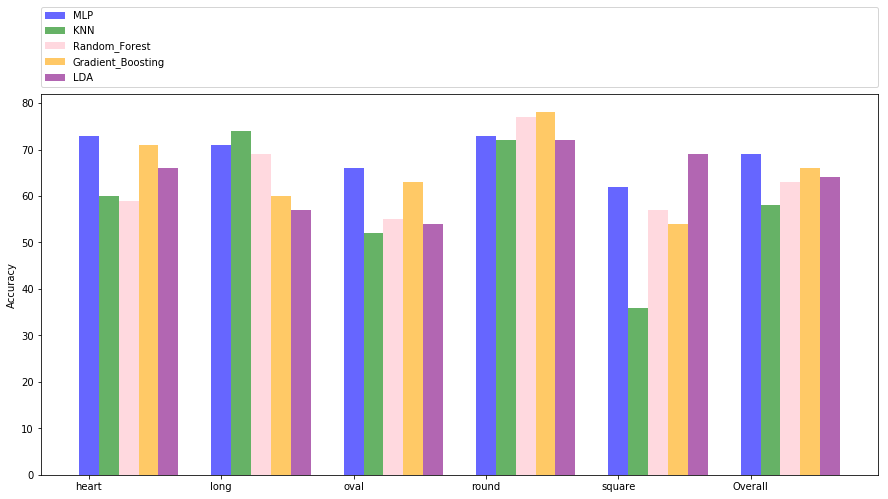

In [99]:
import matplotlib.pyplot as plt

def model_graph():
    ind = np.arange(6)  # the x locations for the groups
    width = 0.15       # the width of the bars

    fig, ax = plt.subplots(figsize=(15, 7))
    al = 0.6
    rects1 = ax.bar(ind, results_df['MLP'], width, color='blue',alpha= al,tick_label = results_df['shape'])
    rects2 = ax.bar(ind + width, results_df['KNN'], width, color='green',alpha= al)
    rects3 = ax.bar(ind + width*2, results_df['Random_Forest'], width, color='pink',alpha= al)
    rects4 = ax.bar(ind + width*3, results_df['Gradient_Boosting'], width, color='orange',alpha= al)
    rects5 = ax.bar(ind + width*4, results_df['LDA'], width, color='purple',alpha= al)

    plt.legend(results_df.iloc[0:0,1:7],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=1, mode="expand", borderaxespad=0.)


    plt.ylabel('Accuracy')
    plt.show()
    
model_graph()

The neural network outperformed the other models for overall performance and for four out of the five shapes.

In [63]:
results_df

,shape,MLP,KNN,Random_Forest,Gradient_Boosting,LDA
0,heart,73.0,60.0,59.0,71.0,60.0
1,long,71.0,74.0,69.0,60.0,59.0
2,oval,66.0,52.0,55.0,63.0,58.0
3,round,73.0,72.0,77.0,78.0,75.0
4,square,62.0,36.0,57.0,54.0,67.0
5,Overall,69.0,58.0,63.0,66.0,64.0
